In [1]:
using QuadGK, LaTeXStrings, Plots, LinearAlgebra, BenchmarkTools;
using DataFrames, CSV,Interpolations,Suppressor;
import JLD,ForwardDiff;
using Plots.PlotMeasures;

In [2]:
gr(frame=:box,size=(400, 300));

In [32]:
const unit = 1.0e-3;
const mpic = 139.57018unit; const mpi0 = 134.9766unit;
const meta = 547.862unit; const mkc = 493.677unit; const mk0 = 497.614unit;
const mpi = (2mpic + mpi0)/3; const mk = (mkc + mk0)/2;
const mπ=mpi;
const mJψ=3.0969;

In [4]:
# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >= 0 ? sqrt(x + 0im) : -sqrt(x - 0im)
end
λ(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z;

# Load data and interpolation

In [5]:
df_ps_pipi_black = sort(DataFrame(CSV.File("./data/ps_pipi_black.csv")));
df_ps_pipi_blue = sort(DataFrame(CSV.File("./data/ps_pipi_blue.csv")));
df_ps_pipi_green = sort(DataFrame(CSV.File("./data/ps_pipi_green.csv")));
df_ps_pipi_red = sort(DataFrame(CSV.File("./data/ps_pipi_red.csv")));

In [6]:
inte_ps_pipi_black = LinearInterpolation(collect(df_ps_pipi_black.Sqrts), collect(df_ps_pipi_black.delta));
inte_ps_pipi_blue = LinearInterpolation(collect(df_ps_pipi_blue.Sqrts), collect(df_ps_pipi_blue.delta));
inte_ps_pipi_green = LinearInterpolation(collect(df_ps_pipi_green.Sqrts), collect(df_ps_pipi_green.delta));
inte_ps_pipi_red = LinearInterpolation(collect(df_ps_pipi_red.Sqrts), collect(df_ps_pipi_red.delta));

In [7]:
inte_ps_pipi_black_s(s)=s<=4*mpi^2 ? 0.0 : inte_ps_pipi_black(sqrt(s))/180*π
inte_ps_pipi_blue_s(s)=s<=4*mpi^2 ? 0.0 : inte_ps_pipi_blue(sqrt(s))/180*π
inte_ps_pipi_green_s(s)=s<=4*mpi^2 ? 0.0 : inte_ps_pipi_green(sqrt(s))/180*π
inte_ps_pipi_red_s(s)=s<=4*mpi^2 ? 0.0 : inte_ps_pipi_red(sqrt(s))/180*π

inte_ps_pipi_red_s (generic function with 1 method)

In [8]:
function phase_pipi_black(s; sth=4*mpi^2, scut=1.85^2)
    if s < sth
        return 0.0
    elseif sth <= s && s <= scut
        return inte_ps_pipi_black_s(s)
    end
    α=3*(π-inte_ps_pipi_black_s(scut))^2/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_black_s(s), scut))
    β=-1+3*(π-inte_ps_pipi_black_s(scut))/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_black_s(s), scut))
    return π-α/(β+(s/scut)^(3/2))
end

function phase_pipi_blue(s; sth=4*mpi^2, scut=1.85^2)
    if s < sth
        return 0.0
    elseif sth <= s && s <= scut
        return inte_ps_pipi_blue_s(s)
    end
    α=3*(π-inte_ps_pipi_blue_s(scut))^2/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_blue_s(s), scut))
    β=-1+3*(π-inte_ps_pipi_blue_s(scut))/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_blue_s(s), scut))
    return π-α/(β+(s/scut)^(3/2))
end

function phase_pipi_green(s; sth=4*mpi^2, scut=1.85^2)
    if s < sth
        return 0.0
    elseif sth <= s && s <= scut
        return inte_ps_pipi_green_s(s)
    end
    α=3*(π-inte_ps_pipi_green_s(scut))^2/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_green_s(s), scut))
    β=-1+3*(π-inte_ps_pipi_green_s(scut))/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_green_s(s), scut))
    return π-α/(β+(s/scut)^(3/2))
end
function phase_pipi_red(s; sth=4*mpi^2, scut=1.85^2)
    if s < sth
        return 0.0
    elseif sth <= s && s <= scut
        return inte_ps_pipi_red_s(s)
    end
    α=3*(π-inte_ps_pipi_red_s(scut))^2/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_red_s(s), scut))
    β=-1+3*(π-inte_ps_pipi_red_s(scut))/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_red_s(s), scut))
    return π-α/(β+(s/scut)^(3/2))
end

phase_pipi_red (generic function with 1 method)

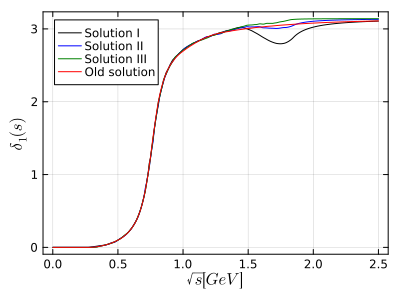

In [9]:
plot(0.0:0.01:2.5,e->phase_pipi_black(e^2),lc=:black,label="Solution I",xlabel=L"\sqrt{s}[GeV]",ylabel=L"\delta_1(s)")
plot!(0.0:0.01:2.5,e->phase_pipi_blue(e^2),lc=:blue,label="Solution II")
plot!(0.0:0.01:2.5,e->phase_pipi_green(e^2),lc=:green,label="Solution III")
plot!(0.0:0.01:2.5,e->phase_pipi_red(e^2),lc=:red,label="Old solution")

In [10]:
function dispersion_integral(f, x, sth; nsub=1)  # these dispersion relation are actually subtracting at s=0
    iϵ = 1e-8im
    res = 0.0im
    if nsub == 1
        integrand1(x′) = f(x′) / (x′ * (x′ - x - iϵ))
        res = quadgk(integrand1, sth, Inf)[1] / π * x
    elseif nsub == 0
        integrand(x′) = f(x′) / (x′ - x - iϵ)
        res = quadgk(integrand, sth, Inf)[1] / π
    end
    return res
end

function Omnes_complex(f, x, sth)
    exp(dispersion_integral(f, x, sth))
end

Omnes_complex (generic function with 1 method)

In [13]:
Ω1_black(s)=Omnes_complex(phase_pipi_black,s,4*mpi^2)
Ω1_blue(s)=Omnes_complex(phase_pipi_blue,s,4*mpi^2)
Ω1_green(s)=Omnes_complex(phase_pipi_green,s,4*mpi^2)
Ω1_red(s)=Omnes_complex(phase_pipi_red,s,4*mpi^2)

Ω1_red (generic function with 1 method)

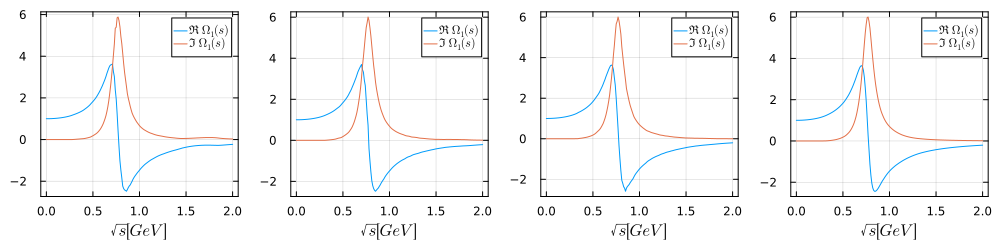

In [15]:
let
    Ev=0.0:0.01:2.0
    resv1=Ω1_black.(Ev .^2)
    resv2=Ω1_blue.(Ev .^2)
    resv3=Ω1_green.(Ev .^2)
    resv4=Ω1_red.(Ev .^2)
    plt1=plot(Ev,real.(resv1),xlabel=L"\sqrt{s}[GeV]",label=L"\Re\ \Omega_1(s)",bottom_margin=7mm)
    plot!(Ev,imag.(resv1),label=L"\Im\ \Omega_1(s)")
    plt2=plot(Ev,real.(resv2),xlabel=L"\sqrt{s}[GeV]",label=L"\Re\ \Omega_1(s)")
    plot!(Ev,imag.(resv2),label=L"\Im\ \Omega_1(s)")
    plt3=plot(Ev,real.(resv3),xlabel=L"\sqrt{s}[GeV]",label=L"\Re\ \Omega_1(s)")
    plot!(Ev,imag.(resv3),label=L"\Im\ \Omega_1(s)")
    plt4=plot(Ev,real.(resv4),xlabel=L"\sqrt{s}[GeV]",label=L"\Re\ \Omega_1(s)")
    plot!(Ev,imag.(resv4),label=L"\Im\ \Omega_1(s)")
    plot(plt1,plt2,plt3,plt4,layout=(1,4),size=(1000,250))
end

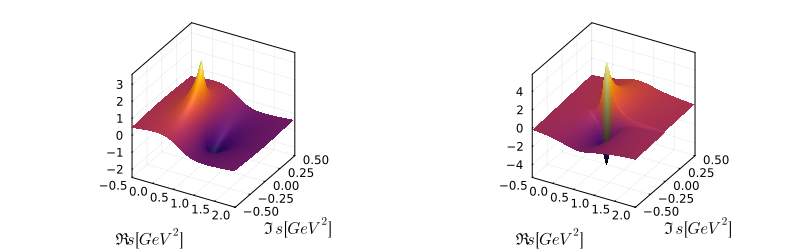

In [30]:
let Resv=-0.5:0.01:2.0,Imsv=-0.5:0.01:0.5
    res_mat=[Ω1_black(x+im*y) for y in Imsv,x in Resv]
    plot(surface(Resv,Imsv,real.(res_mat),xlabel=L"\Re s[GeV^2]",ylabel=L"\Im s[GeV^2]",legend=false),
        surface(Resv,Imsv,imag.(res_mat),xlabel=L"\Re s[GeV^2]",ylabel=L"\Im s[GeV^2]",legend=false),layout=(1,2),size=(800,250))
end

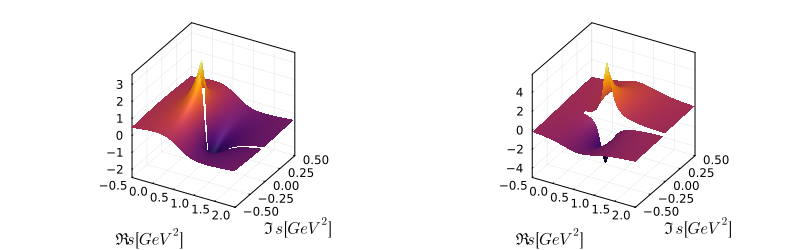

In [31]:
let Resv=-0.5:0.01:2.0,Imsv=-0.5:0.01:0.5
    # set value on the lower rim above the threshold to NaN so that the plot shows the cut
    res_mat=[(x>4*mpi^2&&y≈-0.01) ? NaN+im*NaN : Ω1_black(x+im*y) for y in Imsv,x in Resv]
    plot(surface(Resv,Imsv,real.(res_mat),xlabel=L"\Re s[GeV^2]",ylabel=L"\Im s[GeV^2]",legend=false),
        surface(Resv,Imsv,imag.(res_mat),xlabel=L"\Re s[GeV^2]",ylabel=L"\Im s[GeV^2]",legend=false),layout=(1,2),size=(800,250))
end

# Solve the KT equation

## analytical continuation of mandelstam limits

In [37]:
function κs(s)
    res = zero(ComplexF64)
    if 4*mpi^2 <= s && s < (mJψ - mpi)^2
        res=√abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))
    elseif (mJψ - mpi)^2 <= s && s < (mJψ + mpi)^2
        res=im*√abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))
    elseif s >= (mJψ + mpi)^2
        res=(-1)*√abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))
    end
    return res 
end
function splus(s; ϵ=1.0e-7)
    Σ0 = mJψ^2 + 3*mπ^2 
    res = 0.0im

    if 4*mpi^2 <= s && s < (mJψ - mpi)^2
        res = 1 / 2 * (Σ0 - s + √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) + im * ϵ
    elseif (mJψ - mpi)^2 <= s && s < (mJψ + mpi)^2
        res = 1 / 2 * (Σ0 - s + im * √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) + im * ϵ
    elseif s >= (mJψ + mpi)^2
        res = 1 / 2 * (Σ0 - s - √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) + im * ϵ
    end

    return res
end
function sminus(s; ϵ=1.0e-7)
    Σ0 = mJψ^2 + 3*mπ^2 
    res = 0.0im

    if 4*mpi^2 <= s && s < (mJψ - mpi)^2
        res = 1 / 2 * (Σ0 - s + √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) + im * ϵ
    elseif (mJψ - mpi)^2 <= s && s < (mJψ + mpi)^2
        res = 1 / 2 * (Σ0 - s + im * √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) + im * ϵ
    elseif s >= (mJψ + mpi)^2
        res = 1 / 2 * (Σ0 - s - √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) + im * ϵ
    end

    return res
end
function sminus(s; ϵ=1.0e-7)
    Σ0 = mJψ^2 + 3*mπ^2
    res = 0.0im

    if 4*mpi^2 <= s && s < (mJψ^2 - mpi^2)/2
        res = 1 / 2 * (Σ0 - s - √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) + im * ϵ
    elseif (mJψ^2 - mpi^2)/2 <= s && s < (mJψ - mpi)^2
        res = 1 / 2 * (Σ0 - s - √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) - im * ϵ
    elseif (mJψ - mpi)^2 <= s && s < (mJψ + mpi)^2
        res = 1 / 2 * (Σ0 - s - im * √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) - im * ϵ
    elseif s >= (mJψ + mpi)^2
        res = 1 / 2 * (Σ0 - s + √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) - im * ϵ
    end
end

sminus (generic function with 1 method)

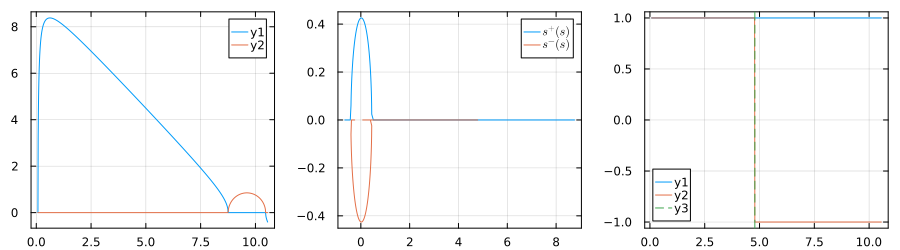

In [41]:
let sv=collect(4*mpi^2:0.01:(mJψ+mpi)^2+0.1)
    plt1=plot(sv,s->real(κs(s)))
    plot!(sv,s->imag(κs(s)))
    
    resv1,resv2=splus.(sv),sminus.(sv)
    #plot the trajectory
    plt2=plot(real.(resv1),imag.(resv1),label=L"s^{+}(s)")
    plot!(real.(resv2),imag.(resv2),label=L"s^{-}(s)")
    #ensure the sign of the imaginary part
    plt3=plot(sv,sign.(imag.(resv1)))
    plot!(sv,sign.(imag.(resv2)))
    vline!([(mJψ^2-mpi^2)/2],ls=:dash)
    
    plot(plt1,plt2,plt3,layout=(1,3),size=(900,250))
end

## solve by iteration